In [4]:
# Guiana_temperature_analysis.ipynb
# Create simple code to reproduce the figures from the paper


## 1) Import modules 

In [94]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime as dt
from datetime import datetime, date, timedelta
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp
import math
import matplotlib.dates as mdates
import seaborn as sns
import sys
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy.stats import theilslopes
import dataframe_image as dfi



In [7]:
# definition of functions used in the script

def kde_intersect(x0,x1):
# returns the proportion of overlap between curves
    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x=np.minimum(kde0_x, kde1_x)
    return(np.trapz(inters_x, x))

def Theilsen(d):
    x=np.arange(len(d.index))
    y=np.array(d.iloc[:,1])
    ts_slope, ts_inter, ts_ls, ts_hs = theilslopes(y, x)  # Note the additional underscores (_) to ignore the last three return values
    return(ts_slope*12, ts_inter, ts_ls*12, ts_hs*12)

## 2) Load datasets

In [10]:
# Paths
inputpath="/Users/gabrielhes/Desktop/PhD/Work/Axis2/FG_microclimatology_paper/Final_analysis/input_data/" 
outputpath="/Users/gabrielhes/Desktop/PhD/Work/Axis2/FG_microclimatology_paper/Final_analysis/output_data/"
figpath='/Users/gabrielhes/Desktop/PhD/Work/Axis2/FG_microclimatology_paper/Final_analysis/figures/'


In [12]:
# open microclimate data
df = pd.read_csv(inputpath+'total_T_understory.csv', dtype={
    'Raw_data_identifier': 'string',
    'Tair': 'float64',
    'ForestName':'string',
    'ForestClass':'string',	
    'Elevation':'float64',	
    'LongTermPM':'bool',
    'Site_id': 'string'}, infer_datetime_format=True, parse_dates=['date'])
ForestNames=df['ForestName'].drop_duplicates()

# open microclimate metadata
m = pd.read_csv(inputpath+'total_TH_metadata.csv', sep=',')# macroclimate

# open ERA5-Land macroclimate data
era = xr.open_dataset(inputpath+'ERA5L_hourly_T2m_2014-2024.nc')-273.15
# shift time to local time zone
era['valid_time']=era.valid_time.to_dataframe()['valid_time'].dt.tz_localize('utc').dt.tz_convert('America/Cayenne').dt.tz_localize(None).values

# Define array of coordinates for forest sites and weather stations
Site_loc=pd.DataFrame({'Site_Name': ['NOU','PAR','LAU','ITO','Kourou','StLau','Saul','CayMat'], 
                       'lat': [4.071667, 5.260416, 5.478813, 3.023333, 5.209167, 5.485500,3.624000,4.822333],
                       'lon': [-52.7325, -52.929874, -53.576096, -53.083611, -52.748000, -54.031667, -53.208167,-52.365333]})
               
# select time series per site
era_nou,era_par,era_lau,era_ito, era_Kourou, era_StLau, era_Saul, era_CayMat =[era.sel(longitude=Site_loc[Site_loc['Site_Name']==s]['lon'].values, latitude=Site_loc[Site_loc['Site_Name']==s]['lat'].values, method="nearest") for s in Site_loc.Site_Name]


# define long-term and short-term sensors
LT=df.loc[df['LongTermPM']] 
ST=df.loc[df['LongTermPM']==False]
print('Number of long and short term sensors: '+str(len(LT['Site_id'].drop_duplicates()))+', '+str(len(ST['Site_id'].drop_duplicates())))

Number of long and short term sensors: 24, 90


## 3) Methods

### 1. Gap-fill end of 2024 for long-term sensors in Paracou and Nouragues

NOU calibration period: 2024-01-01 00:00:00: 2024-07-01 21:00:00
gapfilling sensor NOUB4
gapfilling sensor NOUT3
gapfilling sensor NOUT1
NOU 2024 long-term sensors gapfilled
PAR calibration period: 2024-01-01 00:00:00: 2024-06-11 21:00:00
gapfilling sensor PARS2
gapfilling sensor PART2
gapfilling sensor PART4
PAR 2024 long-term sensors gapfilled


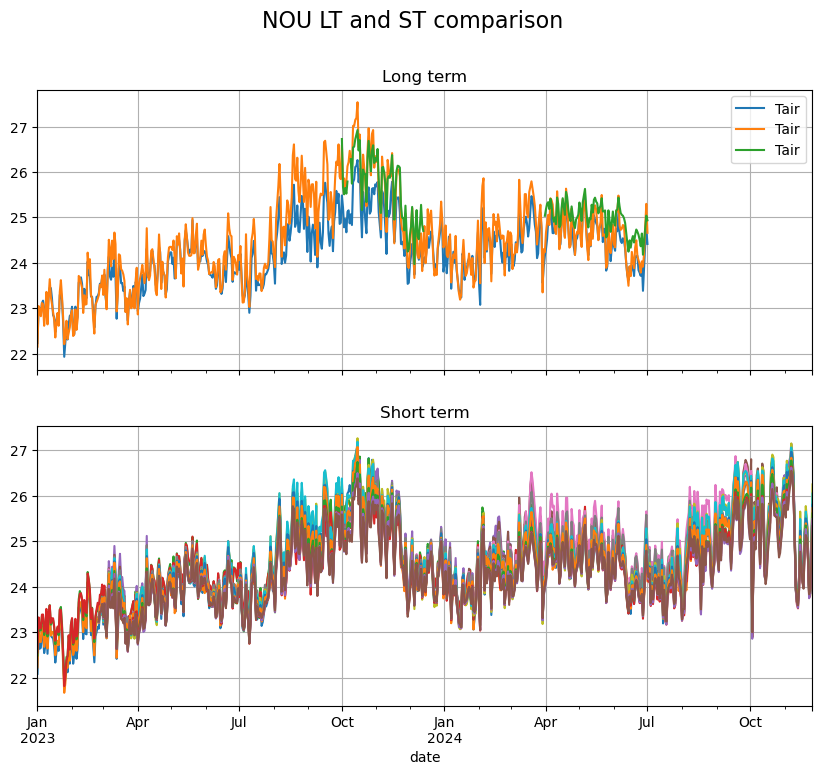

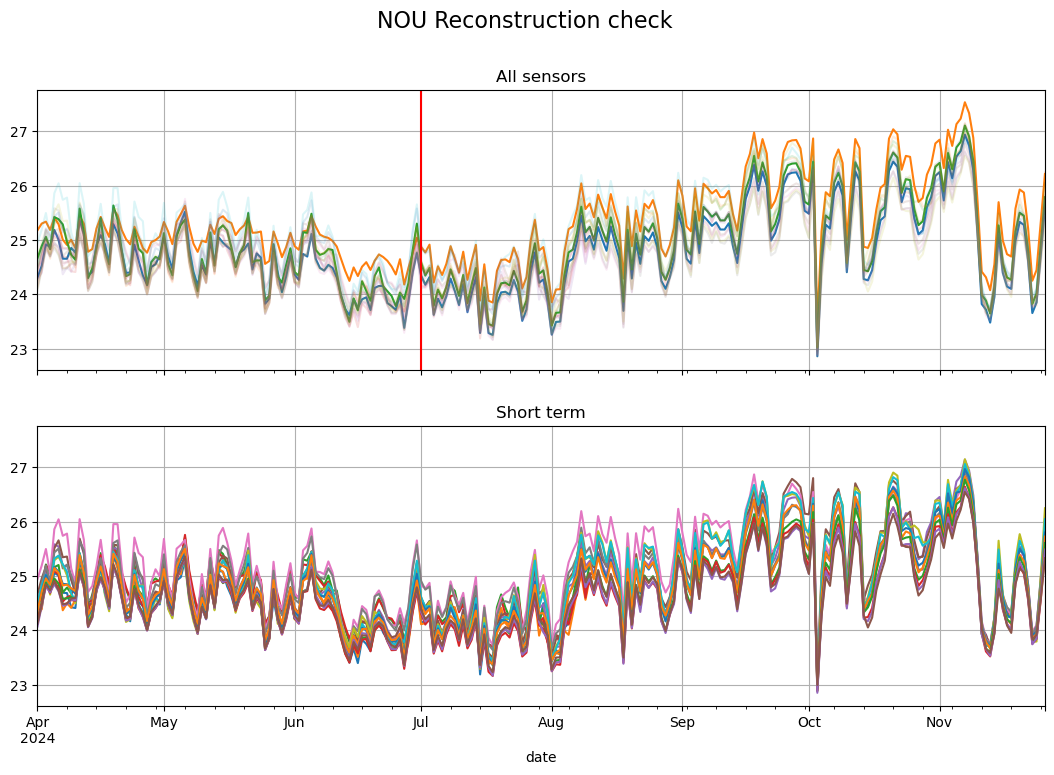

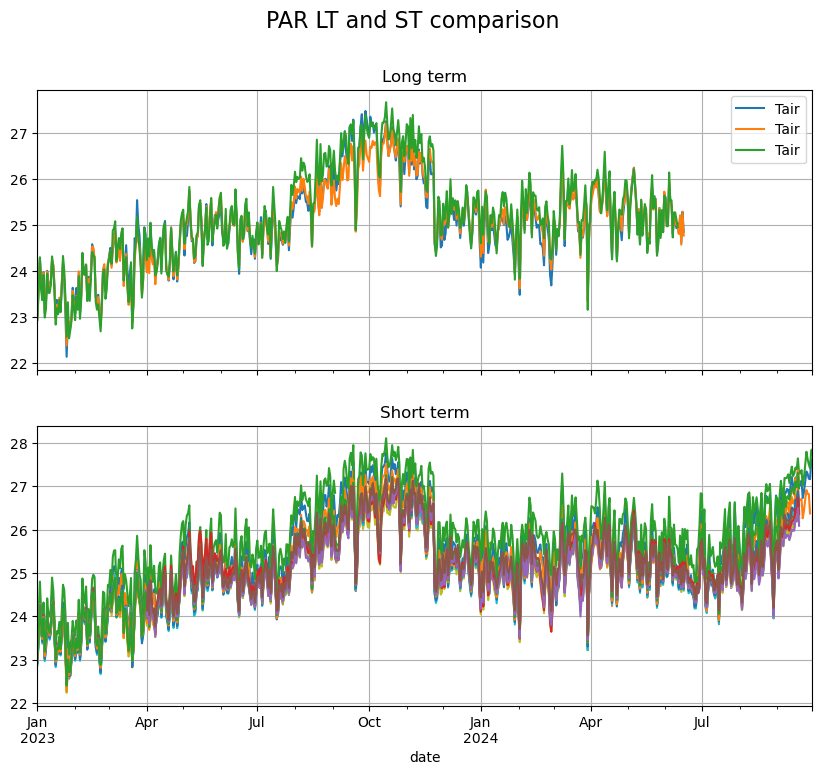

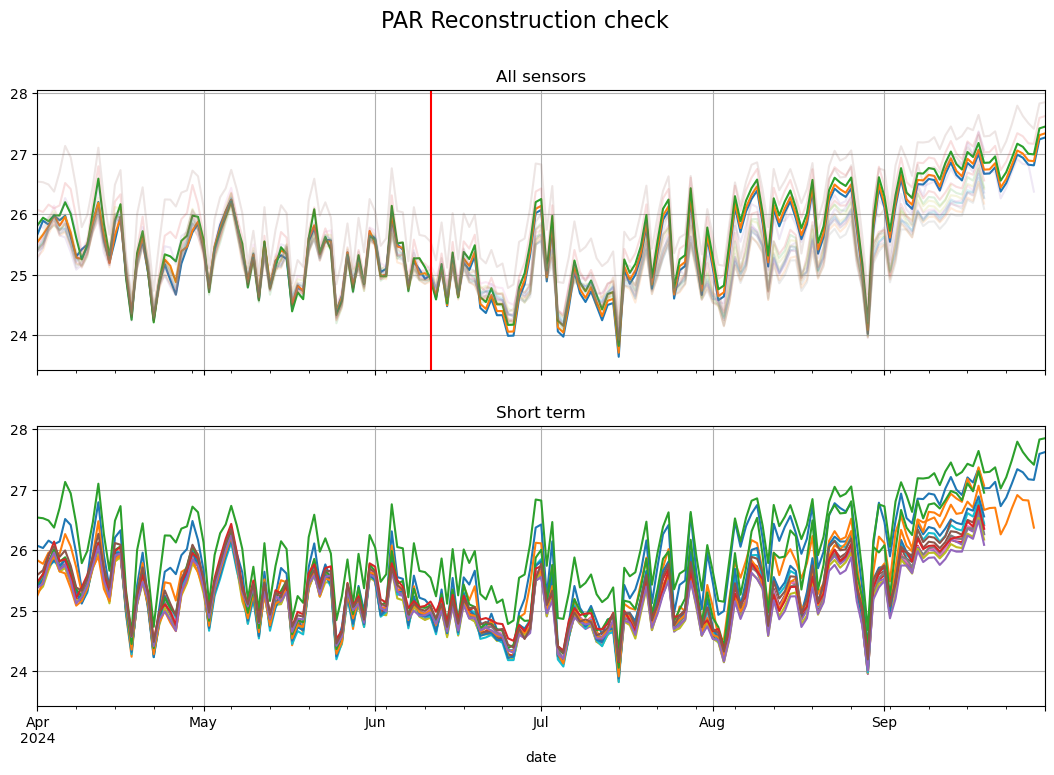

In [13]:
for f in ['NOU','PAR']:
    LTf=LT[(LT['ForestName']==f) & (LT['date']>='2023')]
    STf=ST[(ST['ForestName']==f) & (ST['date']>='2023')]

    ######## inital plot #######
    fig,ax=plt.subplots(2, sharex=True, figsize=(10,8))
    for sid in LTf['Site_id'].drop_duplicates():
        LTf[LTf['Site_id']==sid][['date','Tair']].resample("D",on="date").mean().plot(ax=ax[0])
    for sid in STf['Site_id'].drop_duplicates():
        STf[STf['Site_id']==sid][['date','Tair']].resample("D",on="date").mean().plot(ax=ax[1])
    ax[0].set_title('Long term')
    ax[1].set_title('Short term')
    [axes.grid() for axes in ax]
    ax[1].get_legend().remove()
    fig.suptitle(f+" LT and ST comparison", fontsize=16)

    # Calibration period (date start, date end)
    ds='2024-01-01 00:00:00'
    de=min([LTf[LTf['Site_id']==sid].date.max() for sid in LTf['Site_id'].drop_duplicates()]).strftime('%Y-%m-%d %X')
    print(f+' calibration period: '+str(ds)+': '+str(de))
    
    # compute median and errors over calibration period
    df_cal=df[(df['ForestName']==f) & (df['date']>=ds) & (df['date']<=de)]
    calid=df_cal['Site_id'].drop_duplicates()
    med=df_cal['Tair'].median(numeric_only=True)    
    errors=pd.DataFrame([df_cal[df_cal['Site_id']==sid]['Tair'].mean() - med for sid in calid], index=calid)

    # Reconstruction period
    ds2=(min([LTf[LTf['Site_id']==sid].date.max() for sid in LTf['Site_id'].drop_duplicates()]) + timedelta(hours=1)).strftime('%Y-%m-%d %H:%M:%S')
    de2=(max([STf[STf['Site_id']==sid].date.max() for sid in STf['Site_id'].drop_duplicates()])).strftime('%Y-%m-%d %H:%M:%S')
    df_rec=df[(df['ForestName']==f) & (df['date']>=ds2) & (df['date']<=de2)]

    # select the Sensor from which we rebuild the time series
    STf=STf.set_index('Site_id')
    id0=STf.date.idxmax()
    mednew=df_rec[df_rec['Site_id']==id0]['Tair'].mean()-errors.loc[id0]

    # rebuild the time series 
    for id in LTf['Site_id'].drop_duplicates():
        print('gapfilling sensor '+str(id))
        gf=pd.concat([df_cal[df_cal['Site_id']==id][-1:]]*len(df_rec[df_rec['Site_id']==id0]))
        gf['date']=df_rec[df_rec['Site_id']==id0].date.values
        # remove the error from ST sensor to get the median and add the error from the sensor to rebuild
        gf['Tair']=df_rec[df_rec['Site_id']==id0]['Tair'].values-float(errors.loc[id0])+float(errors.loc[id])

        df=pd.concat([df,gf])

    ####### check plot #######
    LTfc=df[(df['LongTermPM']==True) & (df['ForestName']==f) & (df['date']>='2024-04-01')] 
    STfc=df[(df['LongTermPM']==False) & (df['ForestName']==f) & (df['date']>='2024-04-01')]
    
    fig,ax=plt.subplots(2, sharex=True, sharey=True, figsize=(13,8))
    for sid in LTfc['Site_id'].drop_duplicates():
        LTfc[LTfc['Site_id']==sid][['date','Tair']].resample("D",on="date").mean().plot(ax=ax[0])
    
    for sid in STfc['Site_id'].drop_duplicates():
        STfc[STfc['Site_id']==sid][['date','Tair']].resample("D",on="date").mean().plot(ax=ax[0], alpha=.15)
        STfc[STfc['Site_id']==sid][['date','Tair']].resample("D",on="date").mean().plot(ax=ax[1])
    ax[0].set_title('All sensors')
    ax[1].set_title('Short term')
    [axes.grid() for axes in ax]
    ax[1].get_legend().remove()
    ax[0].get_legend().remove()
    ax[0].axvline(x=ds2,c='r')
    fig.suptitle(f+" Reconstruction check", fontsize=16)
    #plt.savefig(figpath+f+'_LT-2024-reconstruction.png')
    #######

    print(f+' 2024 long-term sensors gapfilled')

df.to_csv(outputpath+'total_T_understory_gf.csv')

### 2. Environmental lapse rate (ELR) correction for microclimate sensors

In [15]:
ELR=-0.00382 # Environmental lapse rate value from Rozante et al. 2022

In [16]:
# create sea-level equivalent temperatures for microclimate sensors
df['Tair_sl']=pd.Series(dtype=float)
df=df.set_index('Site_id')

for sid in df.index.drop_duplicates():   # for each measurement point get the altitude and correct the temperature to the sea level
    df.loc[sid, 'Tair_sl']=df.loc[sid, 'Tair']+ELR*(0-df.loc[sid, 'Elevation'][0])

### 3. ERA5-Land data processing (ELR and debiasing)

### 4. Statistical Analyses

#### a. Derive ERA5-Land monthly and hourly bias from local weather station

In [86]:
ERA_f=pd.concat([era_nou['t2m'][:,0,0].to_dataframe()['t2m'],era_par['t2m'][:,0,0].to_dataframe()['t2m'],era_lau['t2m'][:,0,0].to_dataframe()['t2m'],era_ito['t2m'][:,0,0].to_dataframe()['t2m']],axis=1)
ERA_f.columns=['NOU','PAR','LAU','ITO']
ERA_f=ERA_f.reset_index().rename(columns={'valid_time':'date'}).set_index('date')

In [ ]:
# Get MF site and forest site geo data
alt_ws=pd.read_csv(inputpath+'H_973_latest-2023-2024.csv',sep=';',usecols=[1,4])
for i,name in enumerate(['KOUROU CSG','SAINT LAURENT','SAUL_SAPC','CAYENNE-MATOURY']):
    Site_loc.loc[i+4,'altitude']=alt_ws[alt_ws['NOM_USUEL']==name]['ALTI'].drop_duplicates().values[0]

# Open MF data
MF_Kourou=pd.read_csv(inputpath+'MF_kourouCSG_1980-2024_clean.csv',parse_dates=[1]).rename(columns={'T':'Tair'})
MF_StLau=pd.read_csv(inputpath+'MF_st_laurent_2010-2024_clean.csv',parse_dates=[1]).rename(columns={'T':'Tair'})
MF_CayMat=pd.read_csv(inputpath+'MF_cayenne-matoury_2010-2024_clean.csv',parse_dates=[1]).rename(columns={'T':'Tair'})
MF_Saul=pd.read_csv(inputpath+'MF_saul_2018-2024_clean.csv',parse_dates=[1]).rename(columns={'T':'Tair'})

# resample MF at 1hour frequency
MF_Kourou=MF_Kourou[['date','Tair']].resample('1H', on='date').mean()
MF_StLau=MF_StLau[['date','Tair']].resample('1H', on='date').mean()
MF_CayMat=MF_CayMat[['date','Tair']].resample('1H', on='date').mean()
MF_Saul=MF_Saul[['date','Tair']].resample('1H', on='date').mean()

# select common dates
dstart,dend = '2018-09-14 00:00:00','2024-05-16 00:00:00'
dstartbis= '2018-09-14 00:00:00'
MF_StLau=MF_StLau.loc[dstart:dend]
MF_Kourou=MF_Kourou.loc[dstart:dend]
MF_CayMat=MF_CayMat.loc[dstart:dend]
MF_Saul=MF_Saul.loc[dstart:dend] #loc[dstartbis:dend]

era_StLau=era_StLau.to_dataframe().reset_index()[['valid_time','t2m']].set_index('valid_time').loc[dstart:dend]
era_Kourou=era_Kourou.to_dataframe().reset_index()[['valid_time','t2m']].set_index('valid_time').loc[dstart:dend]
era_CayMat=era_CayMat.to_dataframe().reset_index()[['valid_time','t2m']].set_index('valid_time').loc[dstart:dend]
era_Saul=era_Saul.to_dataframe().reset_index()[['valid_time','t2m']].set_index('valid_time').loc[dstart:dend] #loc[dstartbis:dend]

# drop Nan
idx=MF_StLau['Tair'].loc[pd.isna(MF_StLau['Tair'])].index
MF_StLau=MF_StLau.drop(index=idx)
era_StLau=era_StLau.drop(index=idx)

idx=MF_Kourou['Tair'].loc[pd.isna(MF_Kourou['Tair'])].index
MF_Kourou=MF_Kourou.drop(index=idx)
era_Kourou=era_Kourou.drop(index=idx)

idx=MF_CayMat['Tair'].loc[pd.isna(MF_CayMat['Tair'])].index
MF_CayMat=MF_CayMat.drop(index=idx)
era_CayMat=era_CayMat.drop(index=idx)

idx=MF_Saul['Tair'].loc[pd.isna(MF_Saul['Tair'])].index
MF_Saul=MF_Saul.drop(index=idx)
era_Saul=era_Saul.drop(index=idx)

# Dataframe of macro and microclimate
ERA=pd.concat([era_StLau,era_Kourou,era_CayMat,era_Saul], axis=1)
ERA.columns=['StLau','Kourou','CayMat','Saul']
ERA.index.rename('date',inplace=True)

MF=pd.concat([MF_StLau,MF_Kourou,MF_CayMat,MF_Saul], axis=1)
MF.columns=['StLau','Kourou','CayMat','Saul']

In [110]:
# compute ERA5L ELR correction at MF station

##### Get ERA altitude
# ref https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height#:~:text=To%20obtain%20the%20geopotential%20height,s2%20in%20the%20IFS.
gp=xr.open_dataset(erapath+'/../geopotential_1279l4_0.1x0.1.grib2_v4_unpack.nc')

def convert360_180(_ds):
    """
    convert longitude from 0-360 to -180 -- 180 deg
    """
    # check if already 
    attrs = _ds['longitude'].attrs
    if _ds['longitude'].min() >= 0:
        with xr.set_options(keep_attrs=True): 
            _ds.coords['longitude'] = (_ds['longitude'] + 180) % 360 - 180
        _ds = _ds.sortby('longitude')
    return _ds

gph=convert360_180(gp).isel(time=0)['z']/9.80665 # convert the longitude + compute height
Re=6378000 # in meters
alt_era=np.divide(np.multiply(gph,Re),(Re-gph)) # get the altitude from geopotential height.

for i,name in enumerate(Site_loc['Site_Name']):
    Site_loc.loc[i,'ERA5L_alt']=float(alt_era.sel(longitude=Site_loc[Site_loc['Site_Name']==name]['lon'].values, latitude=Site_loc[Site_loc['Site_Name']==name]['lat'].values, method="nearest"))

ELR=-0.00382
ERA_elr = pd.DataFrame(columns=ERA.columns)
Site_loc=Site_loc.set_index('Site_Name')
for name in ERA.columns:
    ERA_elr[name]=ERA[name]+ELR*(Site_loc.loc[name,'altitude']-Site_loc.loc[name,'ERA5L_alt'])


M
N
X


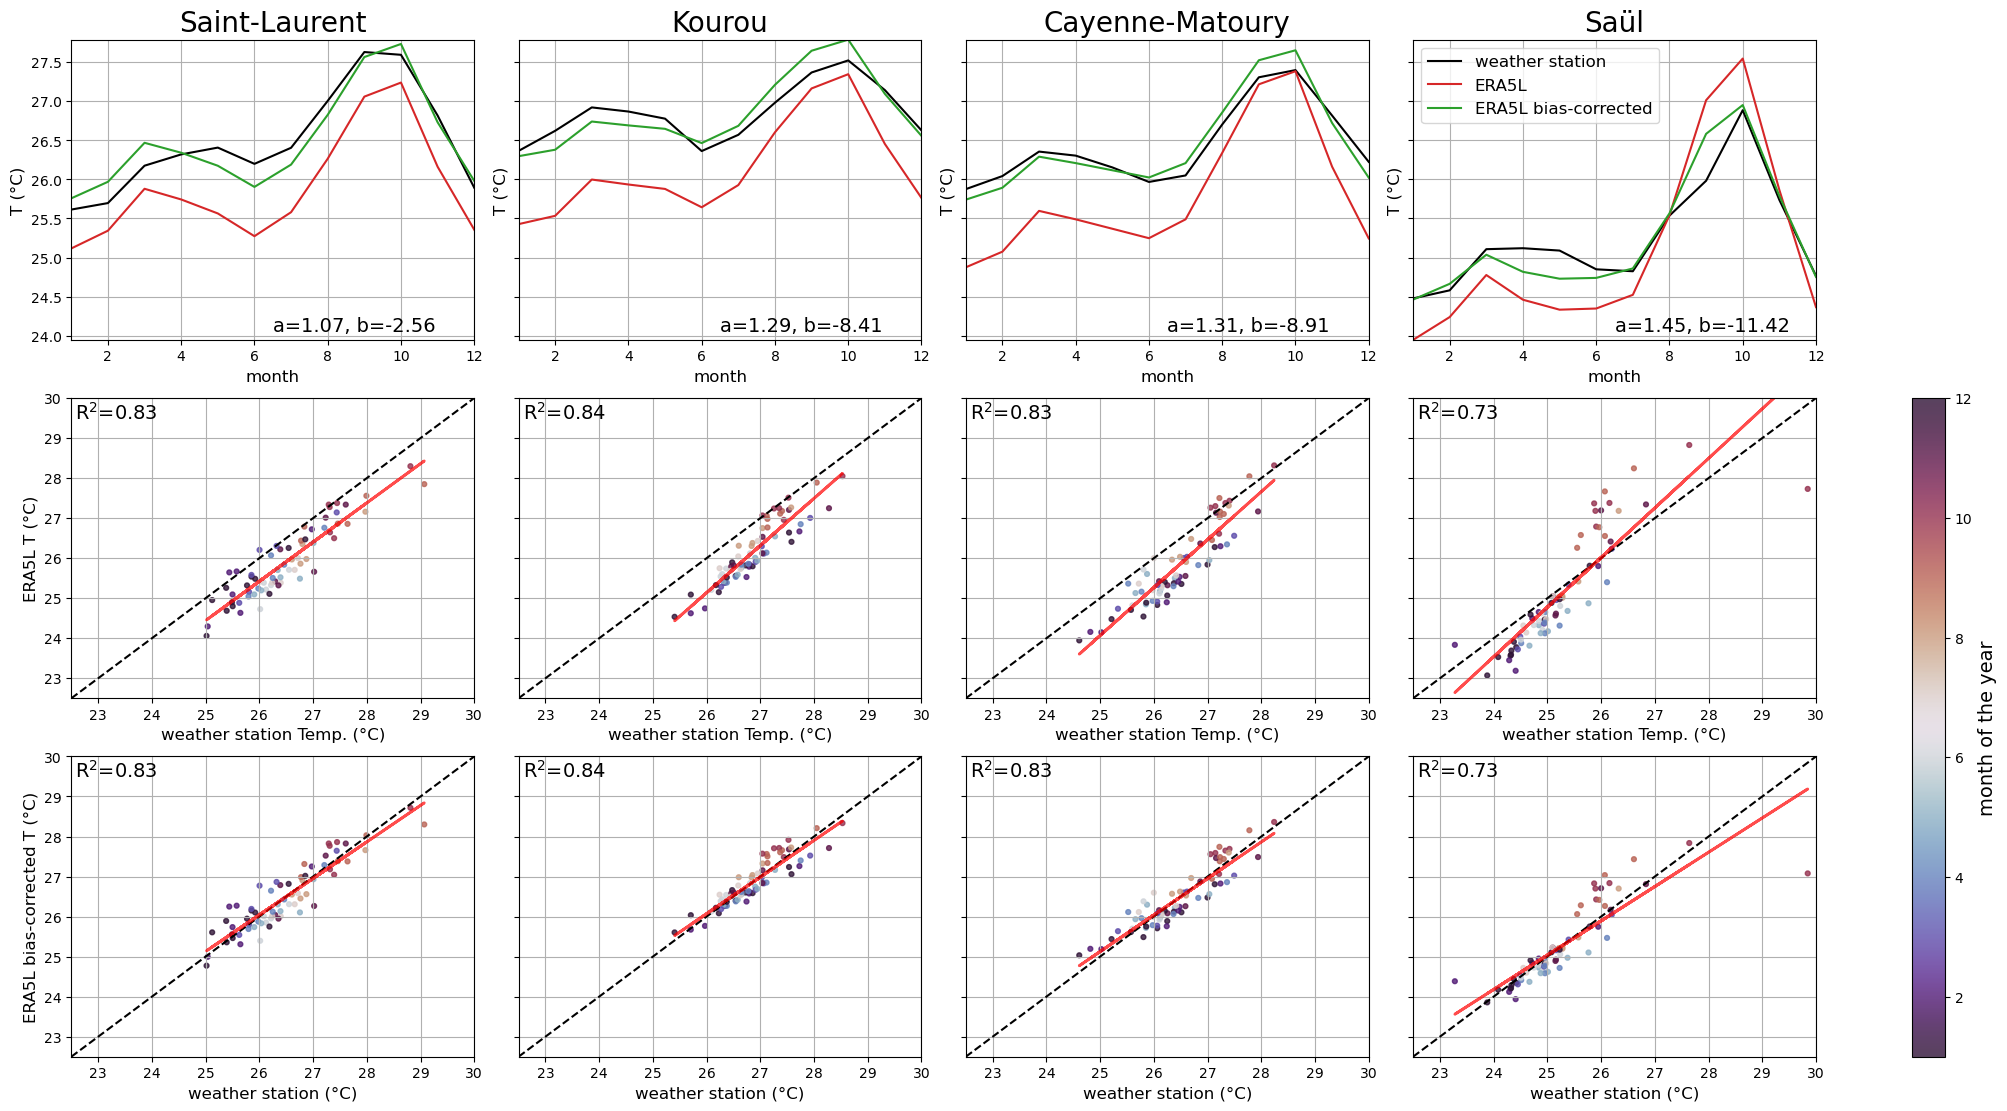

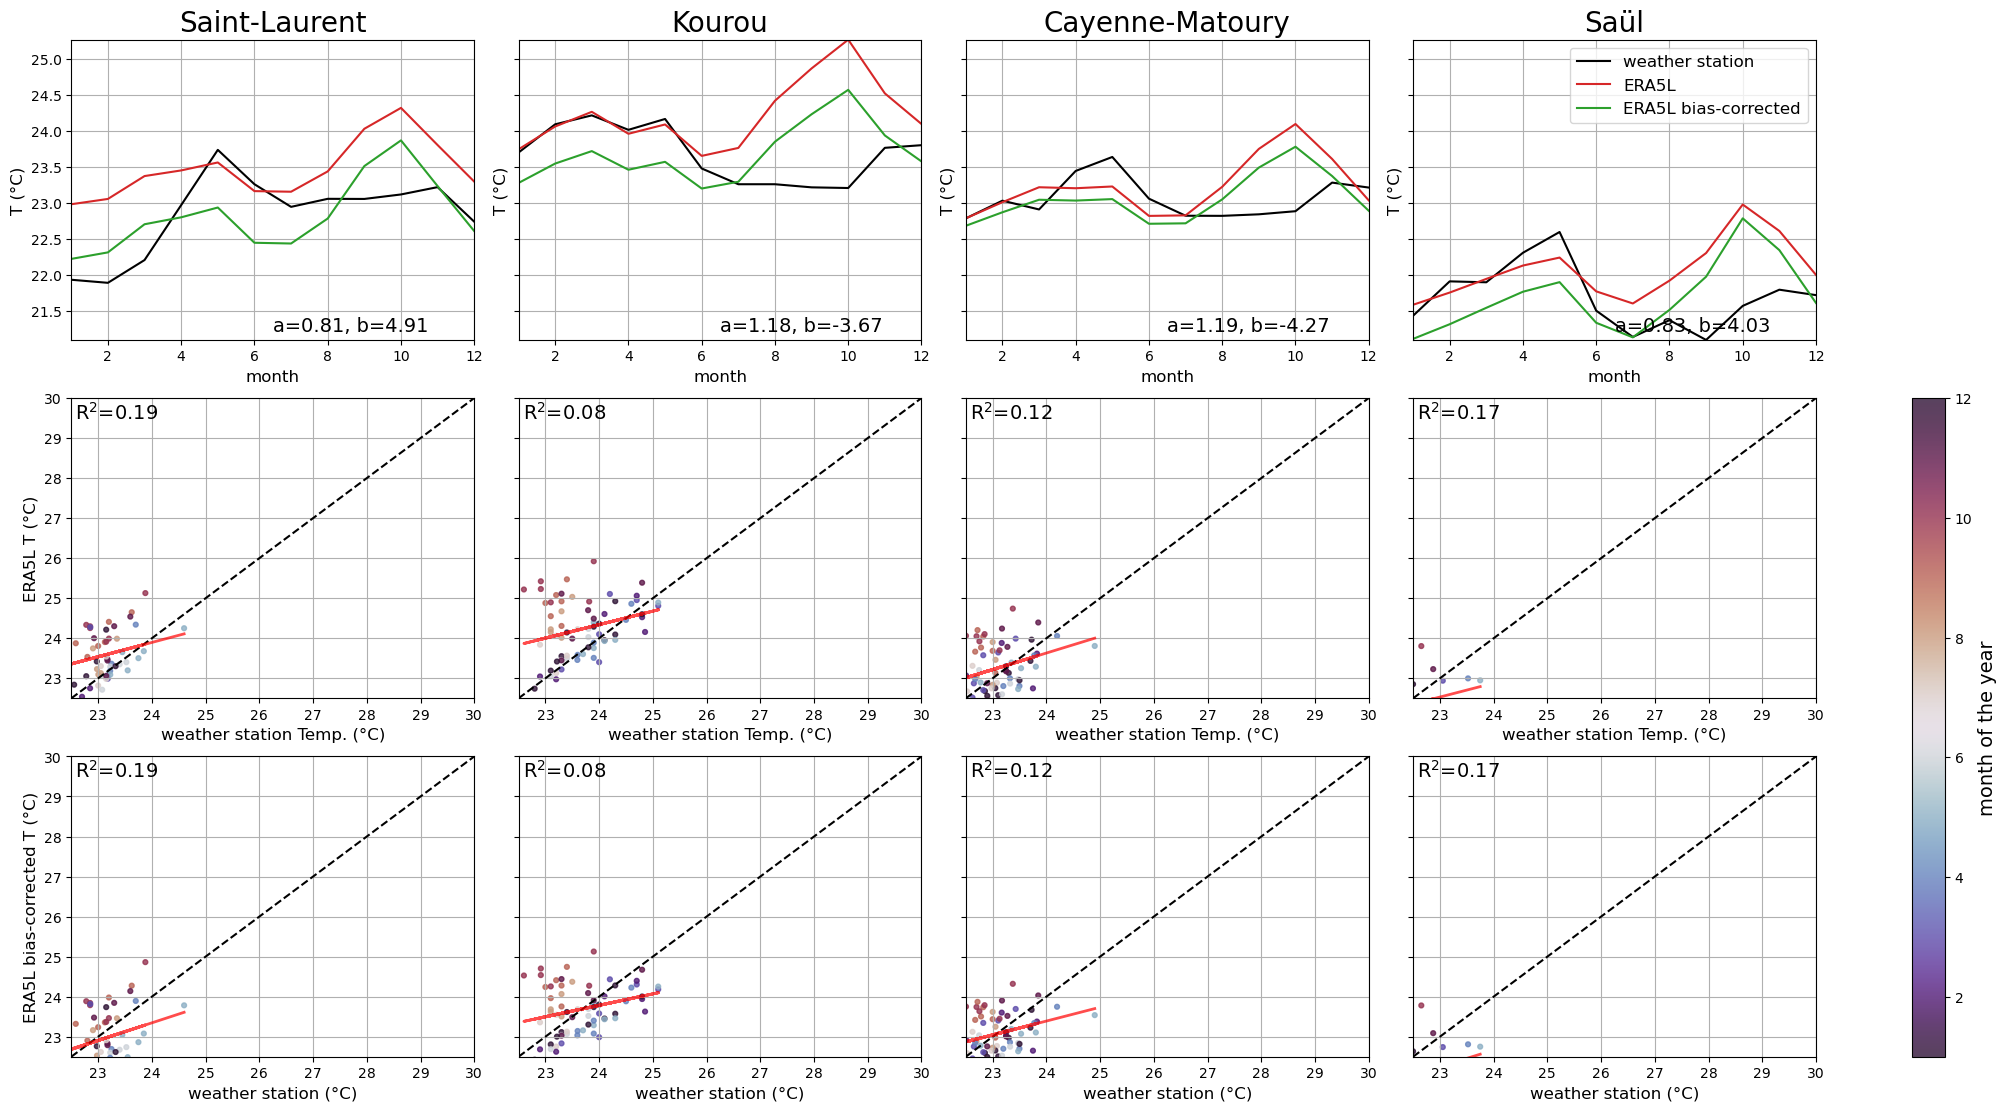

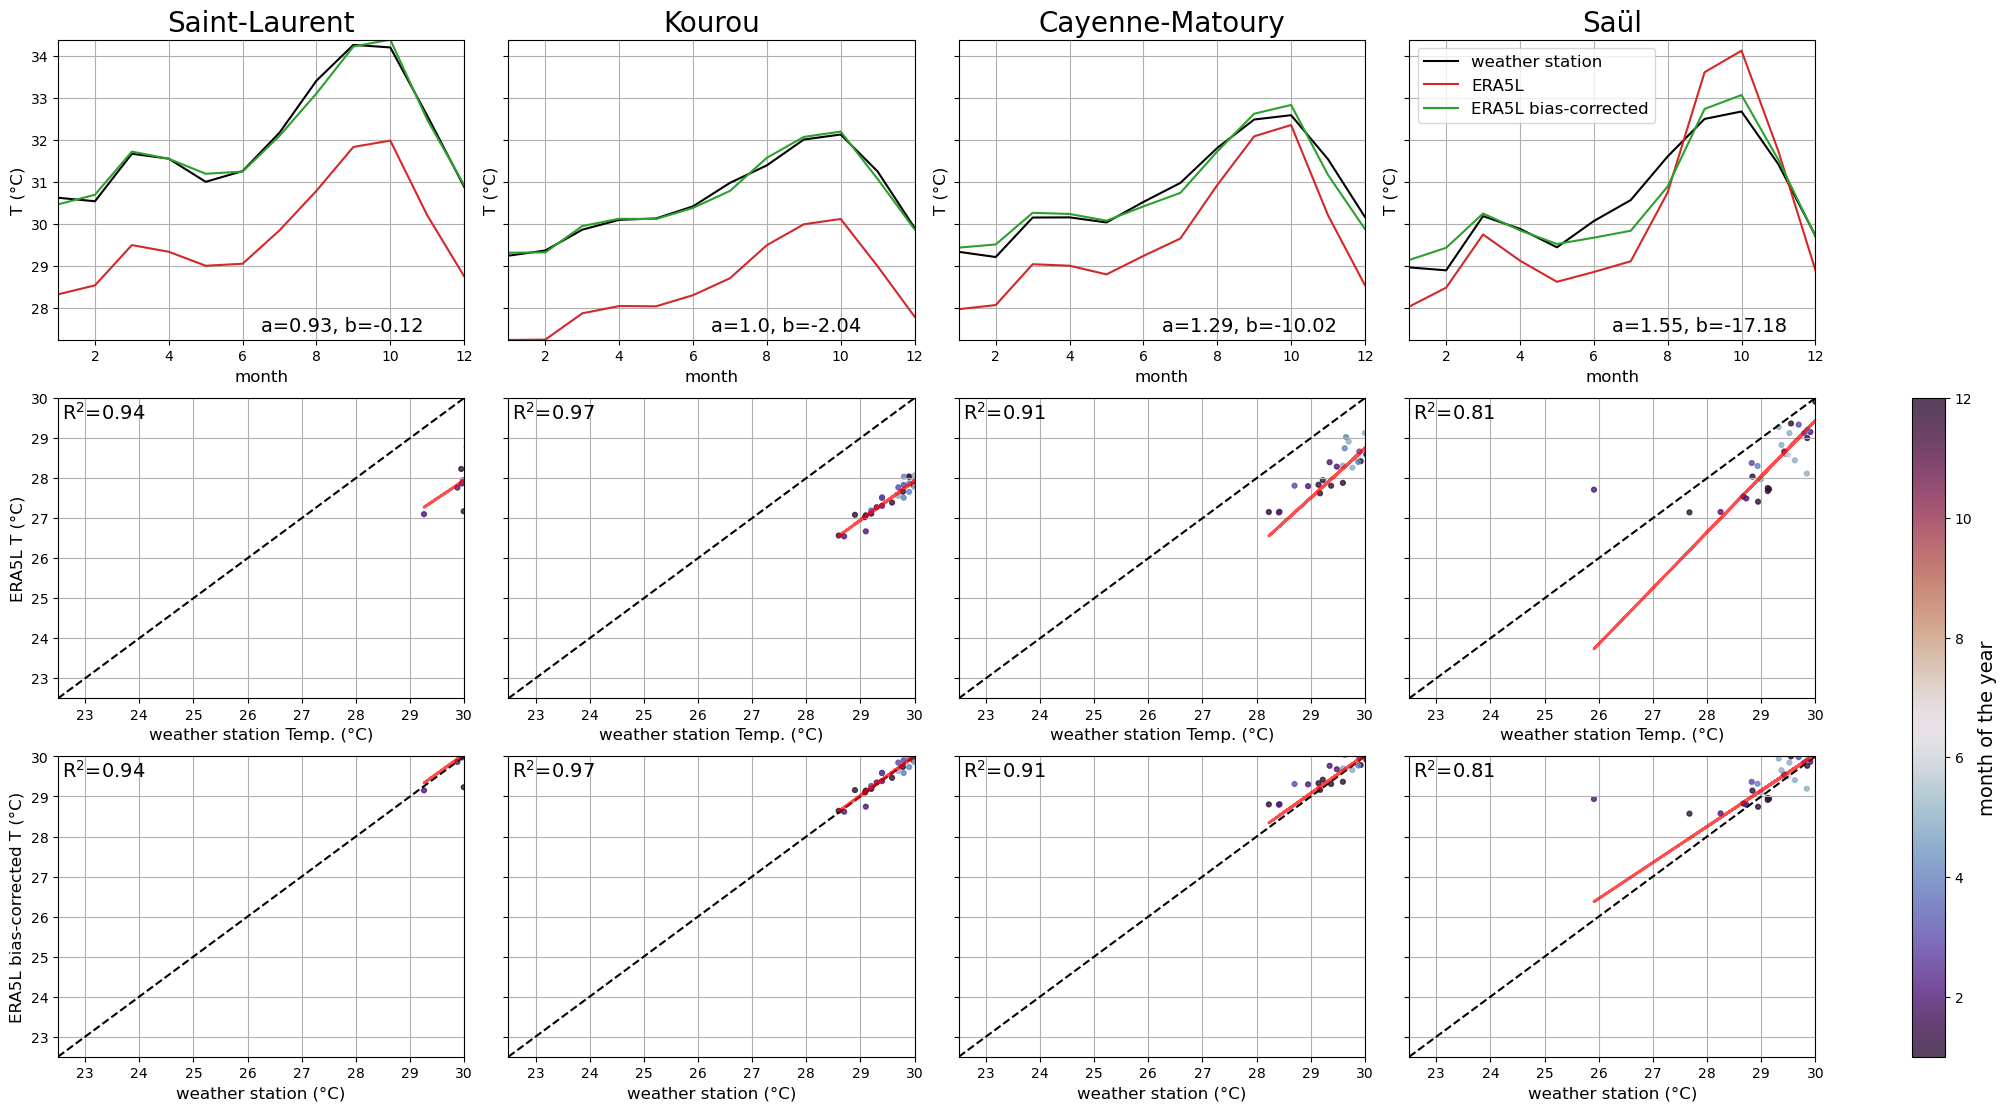

In [115]:
# compute monthly corrections for MF and for ERA5L andERA5L mean bias corrected

Locations=['Saint-Laurent','Kourou','Cayenne-Matoury','Saül']#,'Maripasoula'] 
idnames=['StLau','Kourou','CayMat','Saul']
M_corrections=[]

for stat in ['M','N','X']:
    print(stat)
    a_m=[]
    b_m=[]
    lims=(22.5,30)
    fig, ax = plt.subplots(3,4, figsize=(20,11),sharey='row', constrained_layout=True)

    for i,name in enumerate(idnames):
        #ERA_elr[name]=ERA_elr[name].reset_index().rename(columns={'valid_time':'date'})

        if stat=='M':
            tot=pd.concat([MF[name].reset_index().resample('M',on='date').mean(),ERA_elr[name].reset_index().resample('M',on='date').mean()],axis=1).dropna() # important to remove nan
        if stat=='N':
            tot=pd.concat([MF[name].reset_index().resample('M',on='date').quantile(0.05),ERA_elr[name].reset_index().resample('M',on='date').quantile(0.05)],axis=1).dropna() # important to remove nan
        if stat=='X':
            tot=pd.concat([MF[name].reset_index().resample('M',on='date').quantile(0.95),ERA_elr[name].reset_index().resample('M',on='date').quantile(0.95)],axis=1).dropna() # important to remove nan

        x,y=tot.iloc[:,0],tot.iloc[:,1]
        
        #define month colors
        col=[int(d) for d in MF[name].resample('M').mean().index.month]
        
        a=float(np.std(y)/np.std(x))
        b=float(np.mean(y)-a*np.mean(x))
        #y3=y+x.mean()-y.mean()
        y_cor=(y-b)/a

        # subplot 1
        ax[0,i].plot(x.groupby(x.index.month).mean(), c='k',alpha=1)
        ax[0,i].plot(y.groupby(y.index.month).mean(), c='C3',alpha=1)
        #ax[0,i].plot(y3.groupby(y3.index.month).mean(), c='purple',alpha=.8)
        ax[0,i].plot(y_cor.groupby(y_cor.index.month).mean(), c='C2',alpha=1)

        ax[0,i].set_xlabel('month',fontsize =12)
        ax[0,i].set_ylabel('T (°C)',fontsize =12)
        ax[0,i].set_title(Locations[i],fontsize =20)
        ax[0,i].text(0.5,0.03,'a='+str(round(a,2))+', '+'b='+str(round(b,2)),transform=ax[0,i].transAxes,fontsize =14)
        #ax[i].text(9,0.03,'bias='+str(round(mbias,2)),transform=ax[i].get_xaxis_transform(),fontsize =14)
        a_m.append(round(a,2))
        b_m.append(round(b,2))

        # subplot 2

        reg1 = LinearRegression().fit(np.array(x).reshape(-1,1),y)
        scatter1=ax[1,i].scatter(x,y, s=12, alpha=.8, c=col, cmap='twilight_shifted')
        ax[1,i].axline((25, 25), slope=1,c='k', linestyle='--')
        ax[1,i].plot(x, reg1.predict(np.array(x).reshape(-1,1)), c='r', linewidth=2, alpha=.7)
        ax[1,i].text(0.01,0.93,'R$^2$='+str(round(reg1.score(np.array(x).reshape(-1,1),y),2)),transform=ax[1,i].transAxes, fontsize =14)
        ax[1,i].set_xlabel('weather station Temp. (°C)',fontsize =12)
        ax[1,i].set_xlim(lims)
        ax[1,i].set_ylim(lims)
        ax[0,i].margins(False)


        # subplot 3
        reg2 = LinearRegression().fit(np.array(x).reshape(-1,1),y_cor)
        scatter2=ax[2,i].scatter(x,y_cor, s=12, alpha=.8, c=col, cmap='twilight_shifted')
        ax[2,i].axline((25, 25), slope=1,c='k', linestyle='--')
        ax[2,i].plot(x, reg2.predict(np.array(x).reshape(-1,1)), c='r', linewidth=2, alpha=.7)
        ax[2,i].text(0.01,0.93,'R$^2$='+str(round(reg2.score(np.array(x).reshape(-1,1),y_cor),2)),transform=ax[2,i].transAxes,fontsize =14)
        ax[2,i].set_xlabel('weather station (°C)',fontsize =12)
        ax[2,i].set_xlim(lims)
        ax[2,i].set_ylim(lims)

    [axs.grid() for axs in ax.flat]
    ax[0,i].legend(['weather station','ERA5L','ERA5L bias-corrected'],loc='best',fontsize =12)
    ax[1,0].set_ylabel('ERA5L T (°C)',fontsize =12)
    ax[2,0].set_ylabel('ERA5L bias-corrected T (°C)',fontsize =12)

    cax,kw = mpl.colorbar.make_axes([a for a in ax[1:,:].flat])
    cbar=plt.colorbar(scatter2, cax=cax, **kw)
    cbar.set_label('month of the year',fontsize =14)


    plt.savefig(figpath+'monthly_'+stat+'-ERA5L-MF_bias_2018-2024.png')
    M_corrections.append(pd.DataFrame(data=np.vstack((np.array(a_m),np.array(b_m))).T,columns=['a','b'],index=idnames))


M_corrections_tot=pd.concat({"Tmean": M_corrections[0], "Tmin": M_corrections[1],"Tmax": M_corrections[2]})
M_corrections_tot.to_csv(outputpath+'/../ERA-MF_monthly_'+stat+'_corrections_2018-2024.csv')


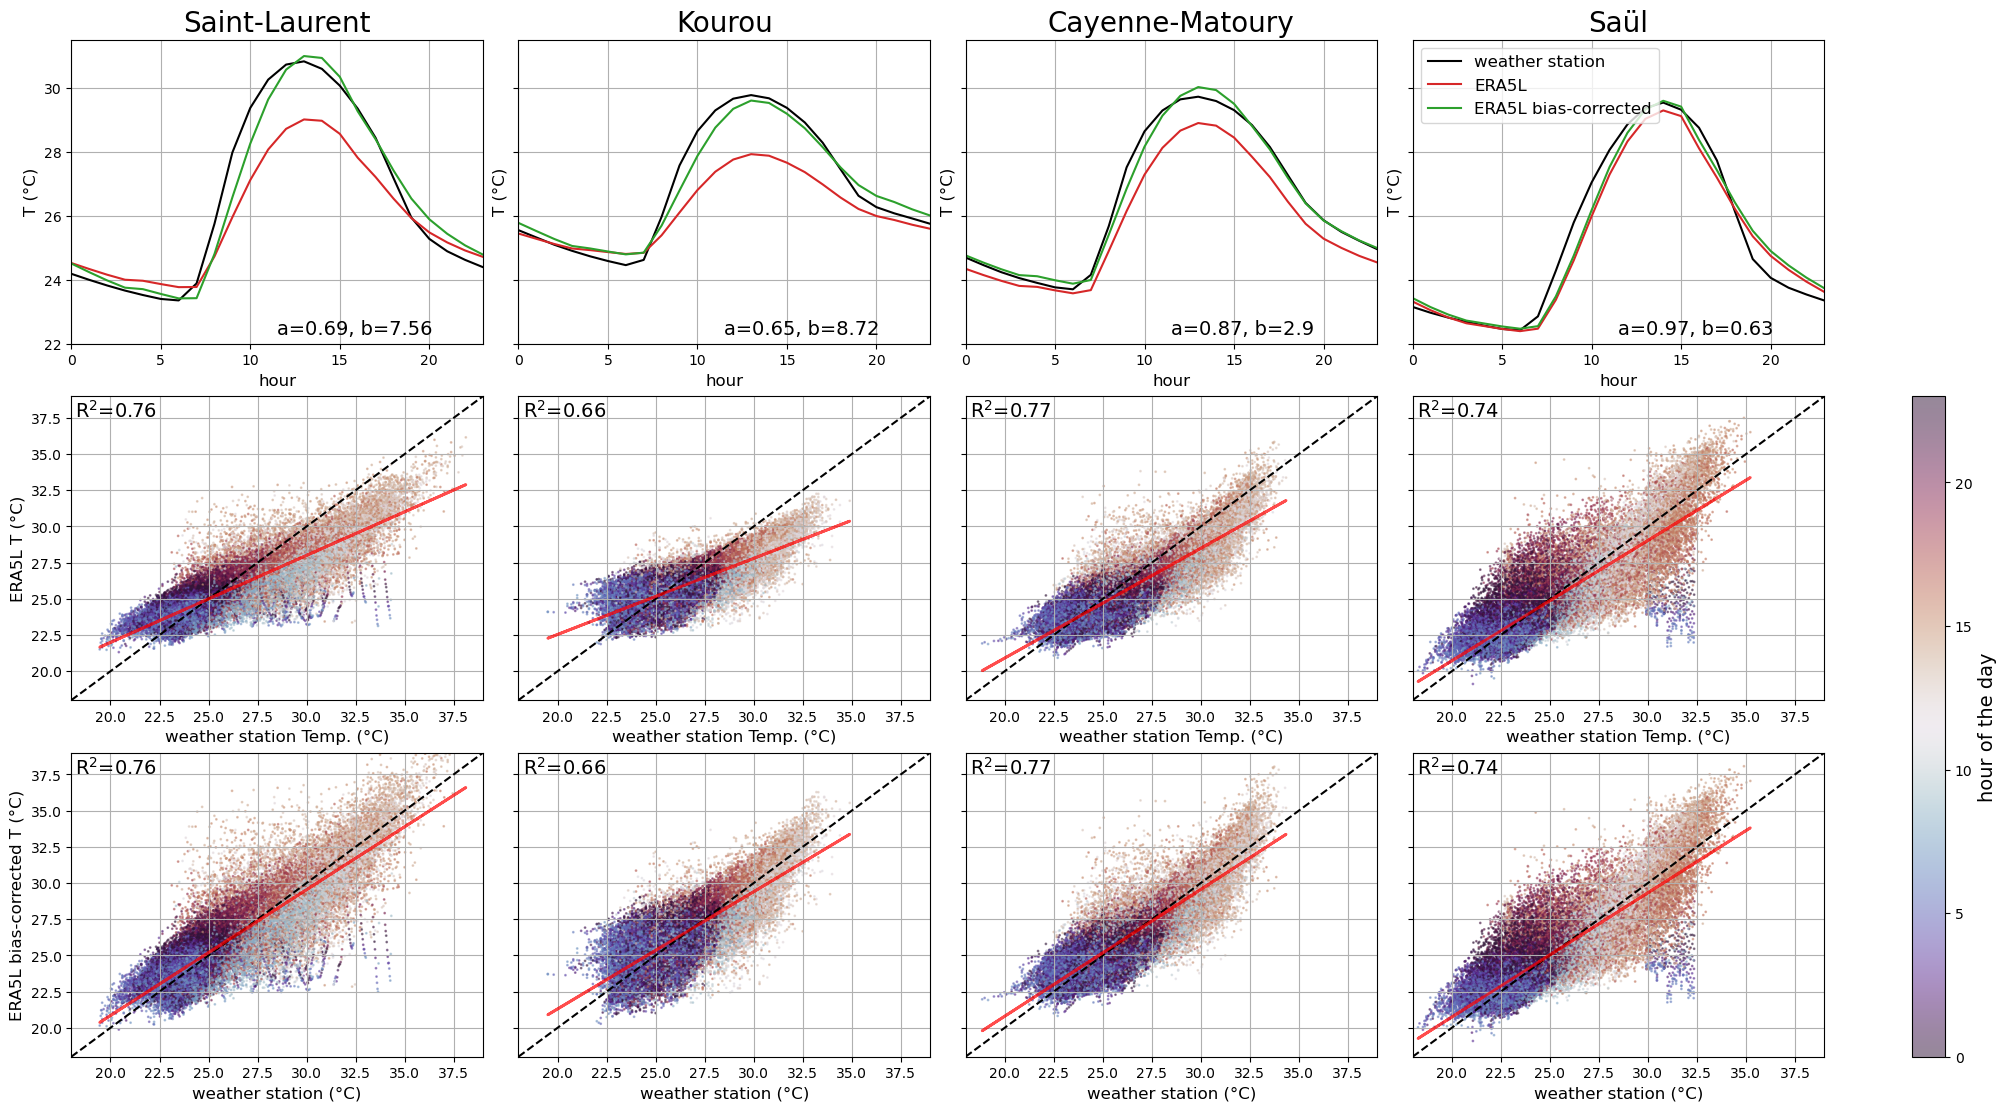

In [118]:
# compute hourly corrections for MF and for ERA5L andERA5L mean bias corrected

fig, ax = plt.subplots(3,4, figsize=(20,11),sharey='row', constrained_layout=True)
Locations=['Saint-Laurent','Kourou','Cayenne-Matoury','Saül']#,'Maripasoula'] 
lims=(18,39)
a_h=[]
b_h=[]
for i,name in enumerate(idnames):
    #ERA_elr[name]=ERA_elr[name].reset_index().rename(columns={'valid_time':'date'})

    tot=pd.concat([MF[name].reset_index().resample('H',on='date').mean(),ERA_elr[name].reset_index().resample('H',on='date').mean()],axis=1).dropna() # important to remove nan
    x,y=tot.iloc[:,0],tot.iloc[:,1]

    #define month colors
    col=[int(d) for d in x.index.hour]
        
    a=float(np.std(y)/np.std(x))
    b=float(np.mean(y)-a*np.mean(x))
    #y3=y+x.mean()-y.mean()
    y_cor=(y-b)/a

    # subplot 1
    ax[0,i].plot(x.groupby(x.index.hour).mean(), c='k',alpha=1)
    ax[0,i].plot(y.groupby(y.index.hour).mean(), c='C3',alpha=1)
    #ax[0,i].plot(y3.groupby(y3.index.month).mean(), c='purple',alpha=.8)
    ax[0,i].plot(y_cor.groupby(y_cor.index.hour).mean(), c='C2',alpha=1)

    ax[0,i].set_xlabel('hour',fontsize =12)
    ax[0,i].set_ylabel('T (°C)',fontsize =12)
    ax[0,i].set_title(Locations[i],fontsize =20)
    ax[0,i].text(0.5,0.03,'a='+str(round(a,2))+', '+'b='+str(round(b,2)),transform=ax[0,i].transAxes,fontsize =14)
    ax[0,i].margins(False)
    ax[0,i].set_ylim((22,31.5))
    #ax[i].text(9,0.03,'bias='+str(round(mbias,2)),transform=ax[i].get_xaxis_transform(),fontsize =14)
    a_h.append(round(a,2))
    b_h.append(round(b,2))

    # subplot 2

    reg1 = LinearRegression().fit(np.array(x).reshape(-1,1),y)
    scatter1=ax[1,i].scatter(x,y, s=1, alpha=.5, c=col, cmap='twilight_shifted')
    ax[1,i].axline((25, 25), slope=1,c='k', linestyle='--')
    ax[1,i].plot(x, reg1.predict(np.array(x).reshape(-1,1)), c='r', linewidth=2, alpha=.7)
    ax[1,i].text(0.01,0.93,'R$^2$='+str(round(reg1.score(np.array(x).reshape(-1,1),y),2)),transform=ax[1,i].transAxes, fontsize =14)
    ax[1,i].set_xlabel('weather station Temp. (°C)',fontsize =12)
    ax[1,i].set_xlim(lims)
    ax[1,i].set_ylim(lims)
    

    # subplot 3
    reg2 = LinearRegression().fit(np.array(x).reshape(-1,1),y_cor)
    scatter2=ax[2,i].scatter(x,y_cor, s=1, alpha=.5, c=col, cmap='twilight_shifted')
    ax[2,i].axline((25, 25), slope=1,c='k', linestyle='--')
    ax[2,i].plot(x, reg2.predict(np.array(x).reshape(-1,1)), c='r', linewidth=2, alpha=.7)
    ax[2,i].text(0.01,0.93,'R$^2$='+str(round(reg2.score(np.array(x).reshape(-1,1),y_cor),2)),transform=ax[2,i].transAxes,fontsize =14)
    ax[2,i].set_xlabel('weather station (°C)',fontsize =12)
    ax[2,i].set_xlim(lims)
    ax[2,i].set_ylim(lims)

[axs.grid() for axs in ax.flat]
ax[0,i].legend(['weather station','ERA5L','ERA5L bias-corrected'],loc='best',fontsize =12)
ax[1,0].set_ylabel('ERA5L T (°C)',fontsize =12)
ax[2,0].set_ylabel('ERA5L bias-corrected T (°C)',fontsize =12)

cax,kw = mpl.colorbar.make_axes([a for a in ax[1:,:].flat])
cbar=plt.colorbar(scatter2, cax=cax, **kw)
cbar.set_label('hour of the day',fontsize =14)


plt.savefig(figpath+'hourly_ERA5L-MF_bias_2018-2024.png')
H_corrections=pd.DataFrame(data=np.vstack((np.array(a_h),np.array(b_h))).T,columns=['a','b'],index=idnames)
H_corrections.to_csv(outputpath+'/../ERA-MF_hourly_corrections_2018-2024.csv')

#### b. Compute ERA5-Land equivalent at sensor elevation using the ELR

In [132]:
# Dataframe of raw ERA values at forest site
ERA_f=pd.concat([era_nou['t2m'][:,0,0].to_dataframe()['t2m'],era_par['t2m'][:,0,0].to_dataframe()['t2m'],era_lau['t2m'][:,0,0].to_dataframe()['t2m'],era_ito['t2m'][:,0,0].to_dataframe()['t2m']],axis=1)
ERA_f.columns=['NOU','PAR','LAU','ITO']
ERA_f=ERA_f.reset_index().rename(columns={'valid_time':'date'}).set_index('date')

l_id=df['Raw_data_identifier'].drop_duplicates()
ERA_f_elr=pd.DataFrame(columns=l_id)


for i,lid in enumerate(l_id):
    f=df[df['Raw_data_identifier']==lid]['ForestName'].values[0]
    z_pm=float(m[m['Site_id']==df[df['Raw_data_identifier']==lid].index.values[0]]['Elevation']) # altitude of point measurement
    z_era=Site_loc.loc[f,'ERA5L_alt'] # altitude of ERA grid
    ERA_f_elr[lid] = ERA_f[f] + ELR * (z_pm-z_era)
print('ERA5L equivalent at sensor elevation')

ERA_f_elr.to_csv(outputpath+'/../ERA5L_elr_at_PM.csv')


ERA5L equivalent at sensor elevation


#### c. Debias ERA5-Land at sensor elevation

In [140]:
# apply monthly corrections

f2ws=dict(zip(ForestNames,['CayMat','Kourou','StLau','Saul']))
ERA_f_elr_m = pd.DataFrame(index=ERA_f_elr.index,columns=ERA_f_elr.columns) # define a df of debiased ERA5L
var='Tmean'

for f in ForestNames:
    print(f)
    # select the logger ids corresponding to this forest site and the monthly correction 
    ids=list(df[df['ForestName']==f]['Raw_data_identifier'].drop_duplicates())

    # Then apply the correction
    ERA_f_elr_m.loc[:,ids] = (ERA_f_elr.loc[:,ids] - M_corrections_tot.loc[(var,f2ws[f]),"b"]) / M_corrections_tot.loc[(var,f2ws[f]),"a"]
print('ERA5L unbiasing at PM finished')

ERA_f_elr_m.to_csv(outputpath+'/../ERA5L_elr_monthly_corrections_at_PM.csv')
print('monthly unbiased ERA at PM saved')

NOU
ITO
PAR
LAU
ERA5L unbiasing at PM finished
monthly unbiased ERA at PM saved


In [143]:
# apply hourly corrections

f2ws=dict(zip(ForestNames,['CayMat','Kourou','StLau','Saul']))
ERA_f_elr_h = pd.DataFrame(index=ERA_f_elr.index,columns=ERA_f_elr.columns) # define a df of debiased ERA5L

for f in ForestNames:
    print(f)
    # select the logger ids corresponding to this forest site and the monthly correction 
    ids=list(df[df['ForestName']==f]['Raw_data_identifier'].drop_duplicates())

    # Then apply the correction
    ERA_f_elr_h.loc[:,ids] = (ERA_f_elr.loc[:,ids] - H_corrections.loc[f2ws[f],"b"]) / H_corrections.loc[f2ws[f],"a"]
print('ERA5L unbiasing at PM finished')

ERA_f_elr_h.to_csv(outputpath+'/../ERA5L_elr_hourly_corrections_at_PM.csv')
print('hourly unbiased ERA at PM saved')

NOU
ITO
PAR
LAU
ERA5L unbiasing at PM finished
hourly unbiased ERA at PM saved


In [ ]:
# add the monhtly and hourly debiased ERA5-Land to the main dataframe
df=df.set_index('date')
df['erac']=pd.Series(dtype=float) #test.set_index(['date','Raw_data_identifier'])
df['erach']=pd.Series(dtype=float) #test.set_index(['date','Raw_data_identifier'])

lid=df['Raw_data_identifier'].drop_duplicates()

for id in lid:
    dindices=list(df[df['Raw_data_identifier']==id].index)
    df.loc[df['Raw_data_identifier']==id,'erac'] = ERA_f_elr_m[ERA_f_elr_m[id].index.isin(dindices)][id]
    df.loc[df['Raw_data_identifier']==id,'erach'] = ERA_f_elr_h[ERA_f_elr_h[id].index.isin(dindices)][id]

df=df.reset_index()

monthly debiased ERA5-Land equivalent at sea-level


#### d. Compute monthly debiased ERA5-Land equivalent at sea-level using the ELR

In [ ]:
ERA_f_sl_m = ERA_f_elr_m.copy(deep=True)

for i,lid in enumerate(l_id):
    z_pm=float(m[m['Site_id']==df[df['Raw_data_identifier']==lid].index.values[0]]['Elevation']) # altitude of point measurement
    ERA_f_sl_m[lid] = ERA_f_elr_m[lid] - ELR * (z_pm)
print('monthly debiased ERA5-Land equivalent at sea-level')

## 4) Results

### Figure 2

'# compute Theilsen trend\nfor temp in [TM,TN,TX]:\n    print(Theilsen(temp.reset_index()))'

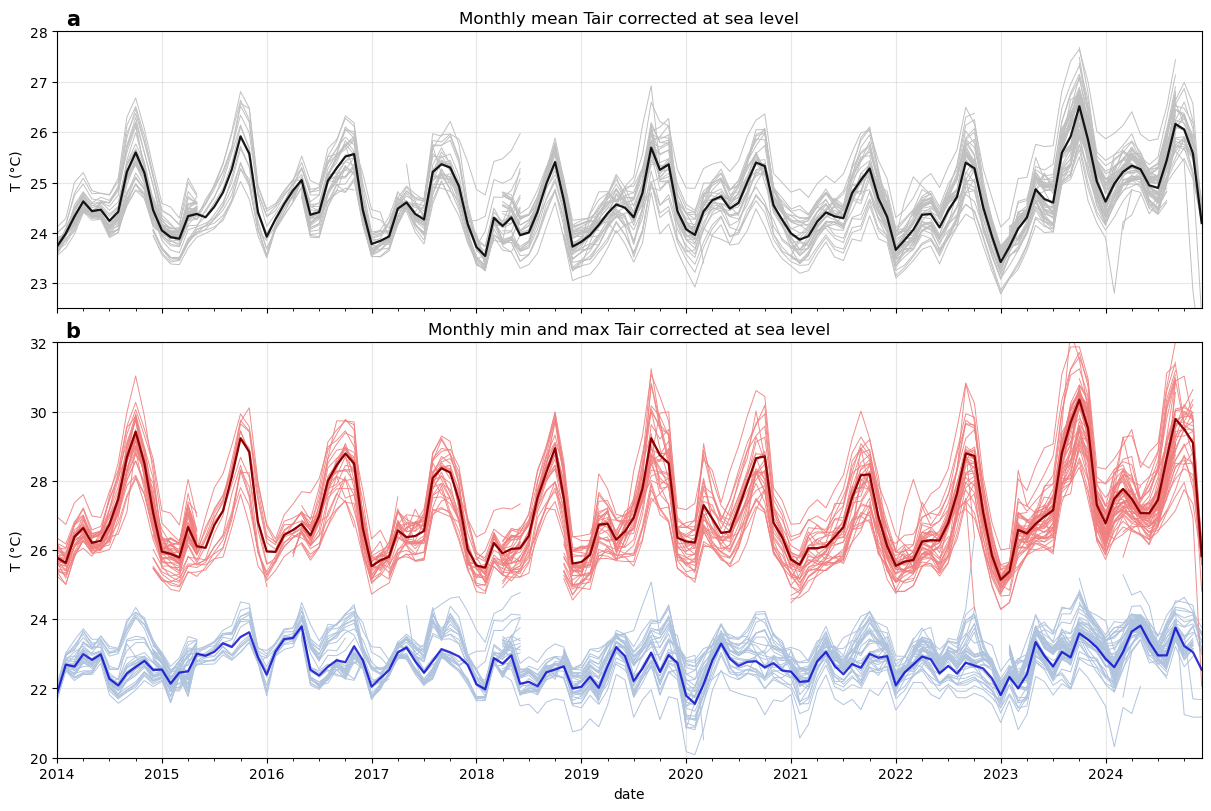

In [20]:
fig, ax=plt.subplots(2,1, sharex=True, figsize=(12, 8),gridspec_kw={'height_ratios': [1, 1.5]}, layout='constrained')
#df=df.set_index('Site_id')
for sid in df.index.drop_duplicates():   
    dm=df.loc[sid,['date','Tair_sl']].resample('M', on='date').mean()
    dx=df.loc[sid,['date','Tair_sl']].resample('M', on='date').quantile(0.95)
    dn=df.loc[sid,['date','Tair_sl']].resample('M', on='date').quantile(0.05)

    dm.plot(ax=ax[0],linewidth=.7, alpha=1, c='silver')
    dn.plot(ax=ax[1],linewidth=.7, alpha=1, c='lightsteelblue')
    dx.plot(ax=ax[1],linewidth=.7, alpha=.9, c='lightcoral')

TM=df.loc[:,['date','Tair_sl']].resample('M', on='date').mean()
TN=df.loc[:,['date','Tair_sl']].resample('M', on='date').quantile(0.05)
TX=df.loc[:,['date','Tair_sl']].resample('M', on='date').quantile(0.95)

TM.plot(c='k',ax=ax[0], linewidth=1.6, alpha=.9)
TN.plot(c='mediumblue',ax=ax[1], linewidth=1.6, alpha=.8)
TX.plot(c='darkred',ax=ax[1], linewidth=1.6, alpha=1)

ax[0].set_title('Monthly mean Tair corrected at sea level')
ax[1].set_title('Monthly min and max Tair corrected at sea level')

[axes.grid(alpha=.3) for axes in ax]
[axes.get_legend().remove() for axes in ax]

ax[0].set_ylim(22.5,28)
ax[1].set_ylim(20,32)

ax[0].text(0.02, 1.08, 'a', transform=ax[0].transAxes,fontsize=15, fontweight='bold', va='top', ha='right') 
ax[1].text(0.02, 1.05, 'b', transform=ax[1].transAxes,fontsize=15, fontweight='bold', va='top', ha='right') 

[ax[i].set_ylabel('T (°C)') for i in range(2)]
plt.savefig(figpath+'fig_2.png')

In [108]:
# define a dataframe for statistics
av=['Tmean','Tmin','Tmax']
slo=['Tmean slope','Tmin slope','Tmax slope']
t_sum=pd.DataFrame(columns=[av+slo], index=['Understory microclimate','Kourou macroclimate']) 

# compute Theilsen trend for microclimate
for i,temp in enumerate([TM,TN,TX]):
    ts_slope, ts_inter, ts_ls, ts_hs=Theilsen(temp.reset_index())
    t_sum.loc['Understory microclimate',av[i]]=str(np.round(temp.mean().values[0],1))+'+/-'+str(np.round(temp.std().values[0],1))
    t_sum.loc['Understory microclimate',slo[i]]=str(np.round(ts_slope,3))+' ['+str(np.round(ts_ls,3))+','+str(np.round(ts_hs,3))+']'

# compute Theilsen trend for Kourou weather station
MFK=pd.read_csv(inputpath+'MF_kourouCSG_2010-2025_clean.csv',parse_dates=[1]).rename(columns={'T':'Tair'}).drop(columns='Unnamed: 0').set_index('date')
d0,d1='2014-01-01 00:00:00','2024-12-31 00:00:00'
Tm=MFK.loc[d0:d1].resample('M').mean(numeric_only=True).reset_index()
for i,temp in enumerate(['Tair','TN','TX']):
    ts_slope, ts_inter, ts_ls, ts_hs=Theilsen(Tm[temp].reset_index())
    t_sum.loc['Kourou macroclimate',av[i]]=str(np.round(Tm[temp].mean(),1))+'+/-'+str(np.round(Tm[temp].std(),1))
    t_sum.loc['Kourou macroclimate',slo[i]]=str(np.round(ts_slope,3))+' ['+str(np.round(ts_ls,3))+','+str(np.round(ts_hs,3))+']'
    
dfi.export(t_sum, outputpath+'stat_table_T_sl_2014-2024.png',table_conversion='selenium')
t_sum

Tmean        Tmin        Tmax  \
Understory microclimate  24.6+/-0.6  22.7+/-0.4  27.0+/-1.2   
Kourou macroclimate      26.7+/-0.6  26.4+/-0.6  27.1+/-0.6   

                                 Tmean slope           Tmin slope  \
Understory microclimate  0.037 [0.005,0.072]   0.015 [-0.01,0.04]   
Kourou macroclimate       0.061 [0.03,0.093]  0.062 [0.031,0.093]   

                                  Tmax slope  
Understory microclimate  0.061 [0.004,0.119]  
Kourou macroclimate      0.061 [0.028,0.094]

### Figure 3

24.451592292811902 23.476959446352943
2.0771267709618817 1.4606221365841023


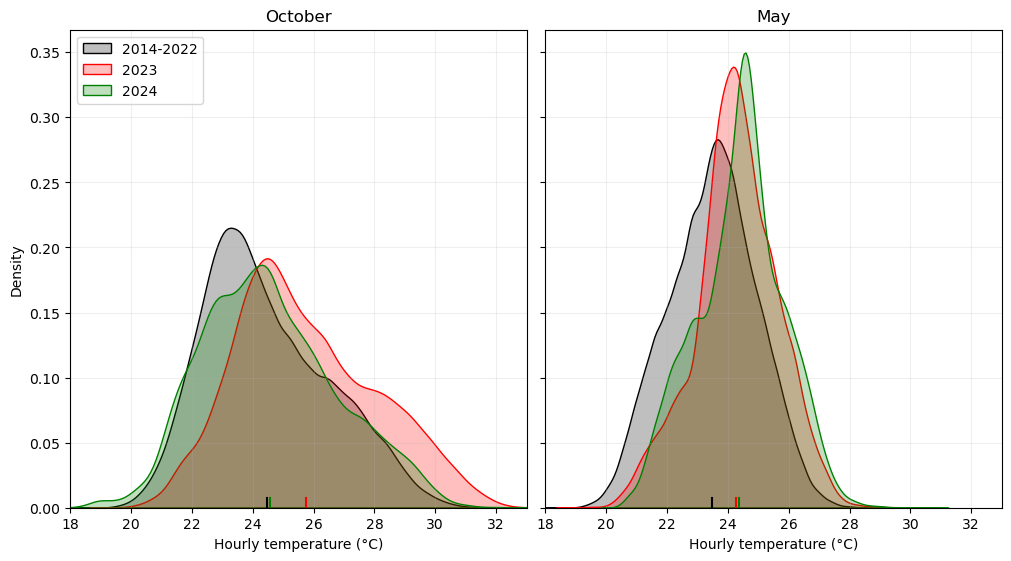

In [668]:
# select may and october month for the old period (2014-2022) and year 2023
may_old=df[(df['date'].dt.month==5)&(df['date'].dt.year<2023)]
may_23=df[(df['date'].dt.month==5)&(df['date'].dt.year>=2023)]
oct_old=df[(df['date'].dt.month==10)&(df['date'].dt.year<2023)]
oct_23=df[(df['date'].dt.month==10)&(df['date'].dt.year>=2023)]

# creaate figure

fig,ax=plt.subplots(1,2, figsize=(10,5.5), sharey=True,sharex=True, layout='constrained')
may_old=df[(df['date'].dt.month==5)&(df['date'].dt.year<2023)]
may_23=df[(df['date'].dt.month==5)&(df['date'].dt.year==2023)]
may_24=df[(df['date'].dt.month==5)&(df['date'].dt.year==2024)]
oct_old=df[(df['date'].dt.month==10)&(df['date'].dt.year<2023)]
oct_23=df[(df['date'].dt.month==10)&(df['date'].dt.year==2023)]
oct_24=df[(df['date'].dt.month==10)&(df['date'].dt.year==2024)]

sns.kdeplot(oct_old['Tair'], fill=True, color="k", ax=ax[0])
sns.kdeplot(oct_23['Tair'], fill=True, color="r", ax=ax[0])
sns.kdeplot(oct_24['Tair'], fill=True, color="g", ax=ax[0])
sns.kdeplot(may_old['Tair'], fill=True, color="k", ax=ax[1])
sns.kdeplot(may_23['Tair'], fill=True, color="r", ax=ax[1])
sns.kdeplot(may_24['Tair'], fill=True, color="g", ax=ax[1])

print(oct_old['Tair'].mean(),may_old['Tair'].mean())
print(oct_old['Tair'].std(),may_old['Tair'].std())

ax[0].axvline(x=oct_old['Tair'].mean(), ymin=0, ymax=0.02,c="k")
ax[1].axvline(x=may_old['Tair'].mean(), ymin=0, ymax=0.02,c="k")
ax[0].axvline(x=oct_23['Tair'].mean(), ymin=0, ymax=0.02,c="r")
ax[1].axvline(x=may_23['Tair'].mean(), ymin=0, ymax=0.02,c="r")
ax[0].axvline(x=oct_24['Tair'].mean(), ymin=0, ymax=0.02,c="g")
ax[1].axvline(x=may_24['Tair'].mean(), ymin=0, ymax=0.02,c="g")

ax[0].set(ylabel=None)
ax[1].set(ylabel=None)

ax[0].legend(['2014-2022','2023','2024'],loc='upper left')
ax[0].set_xlim(18,33)
ax[0].set_title('October')
ax[1].set_title('May')
ax[0].set_ylabel('Density')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Hourly temperature (°C)')
ax[1].set_xlabel('Hourly temperature (°C)')
[a.grid(alpha=.2) for a in ax]
plt.savefig(figpath+'fig_3.png')


### Figure S9

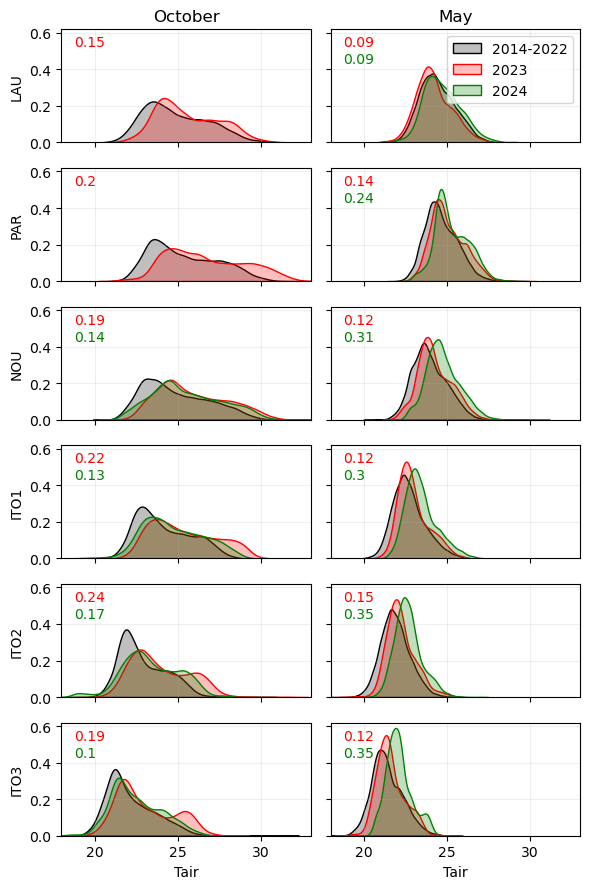

In [670]:
ForestClasses=['LAU','PAR','NOU','ITO1','ITO2','ITO3']
fig,ax=plt.subplots(6,2, sharey=True,sharex=True, layout='tight', figsize=(6,9))
for i,f in enumerate(ForestClasses):
    d=df[df['ForestClass']==f]
    may_old=d[(d['date'].dt.month==5)&(d['date'].dt.year<2023)]
    may_23=d[(d['date'].dt.month==5)&(d['date'].dt.year==2023)]
    may_24=d[(d['date'].dt.month==5)&(d['date'].dt.year==2024)]

    oct_old=d[(d['date'].dt.month==10)&(d['date'].dt.year<2023)]
    oct_23=d[(d['date'].dt.month==10)&(d['date'].dt.year==2023)]
    oct_24=d[(d['date'].dt.month==10)&(d['date'].dt.year==2024)]

    #sns.set_theme(style="darkgrid")
    
    sns.kdeplot(oct_old['Tair'], fill=True, color="k", ax=ax[i,0])
    sns.kdeplot(oct_23['Tair'], fill=True, color="r", ax=ax[i,0])
    if not oct_24['Tair'].empty:
        sns.kdeplot(oct_24['Tair'], fill=True, color="g", ax=ax[i,0])
    sns.kdeplot(may_old['Tair'], fill=True, color="k", ax=ax[i,1])
    sns.kdeplot(may_23['Tair'], fill=True, color="r", ax=ax[i,1])
    sns.kdeplot(may_24['Tair'], fill=True, color="g", ax=ax[i,1])

    ax[i,0].set(ylabel=f)
    ax[i,1].set(ylabel=None)
    ax[i,0].text(0.05,0.85, str(np.round(1-kde_intersect(oct_old['Tair'],oct_23['Tair']),2)) ,c='r',transform=ax[i,0].transAxes)
    ax[i,1].text(0.05,0.85, str(np.round(1-kde_intersect(may_old['Tair'],may_23['Tair']),2))  ,c='r',transform=ax[i,1].transAxes)
    if not oct_24['Tair'].empty:
        ax[i,0].text(0.05,0.7, str(np.round(1-kde_intersect(oct_old['Tair'],oct_24['Tair']),2)), c='g', transform=ax[i,0].transAxes)
    ax[i,1].text(0.05,0.7, str(np.round(1-kde_intersect(may_old['Tair'],may_24['Tair']),2)) ,c='g', transform=ax[i,1].transAxes)
    ax[i,0].grid(alpha=.2)
    ax[i,1].grid(alpha=.2)

ax[0,1].legend(['2014-2022','2023','2024'],loc='upper right',fontsize=10)
ax[0,0].set_xlim(18,33)
ax[0,0].set_title('October')
ax[0,1].set_title('May')

plt.savefig(figpath+'fig_S9.png', dpi=300)


### Figure 4

In [396]:
# compute anomaly and total variance  
anomean,anomax,anomin=pd.Series(dtype='float64'),pd.Series(dtype='float64'),pd.Series(dtype='float64')
ts_m=df.loc[:,['date','Tair_sl']].resample('M', on='date').mean()
ts_x=df.loc[:,['date','Tair_sl']].resample('M', on='date').quantile(.95)
ts_n=df.loc[:,['date','Tair_sl']].resample('M', on='date').quantile(.05)

for k,pmid in enumerate(df.index.drop_duplicates()):
    am= df.loc[pmid,['date','Tair_sl']].resample('M', on='date').mean() - ts_m
    ax= df.loc[pmid,['date','Tair_sl']].resample('M', on='date').quantile(.95) - ts_x
    an= df.loc[pmid,['date','Tair_sl']].resample('M', on='date').quantile(.05) - ts_n
    anomean = pd.concat([anomean,am],axis=1)
    anomax= pd.concat([anomax,ax],axis=1)
    anomin = pd.concat([anomin,an],axis=1)

[k.drop(columns=0, inplace=True) for k in [anomean,anomax,anomin]]
#anom.to_csv(outputpath+'deviation-from-mean_per-MP.csv')

anomean=anomean.stack().reset_index().rename(columns={0:'Anom'})
anomax=anomax.stack().reset_index().rename(columns={0:'Anom'})
anomin=anomin.stack().reset_index().rename(columns={0:'Anom'})
print(anomean.std())

NOU
NOU    0.231123
dtype: float64
ITO
ITO    0.332077
dtype: float64
PAR
PAR    0.22307
dtype: float64
LAU
LAU    0.357625
dtype: float64


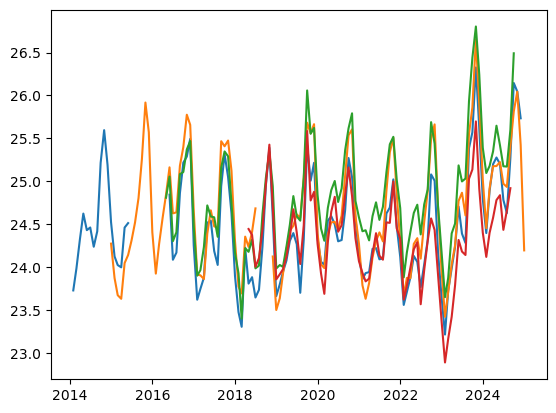

In [408]:
# Compute Intrasite variance ofr each forest site
Forest_anom=[]
fig,ax=plt.subplots(1)
for i,fs in enumerate(ForestNames):
    print(fs)
    anomean,anomax,anomin=pd.Series(dtype='float64'),pd.Series(dtype='float64'),pd.Series(dtype='float64')

    dfs=df[(df.ForestName==fs)]# & (df.date.dt.year==2023)]
    ts_m=dfs.loc[:,['date','Tair_sl']].resample('M', on='date').mean()
    ax.plot(ts_m)
    for k,pmid in enumerate(dfs.index.drop_duplicates()):
        am= dfs.loc[pmid,['date','Tair_sl']].resample('M', on='date').mean() - ts_m
        anomean = pd.concat([anomean,am],axis=1)    

    [k.drop(columns=0, inplace=True) for k in [anomean,anomax,anomin]]
#anom.to_csv(inputpath+'deviation-from-mean_per-MP.csv')
    anomean=anomean.stack().reset_index().rename(columns={0:fs,'level_0':'date'}).drop(columns='level_1').set_index('date')
    
    Forest_anom.append(anomean)
    print(anomean.std())
    
Forest_anom=pd.concat(Forest_anom)

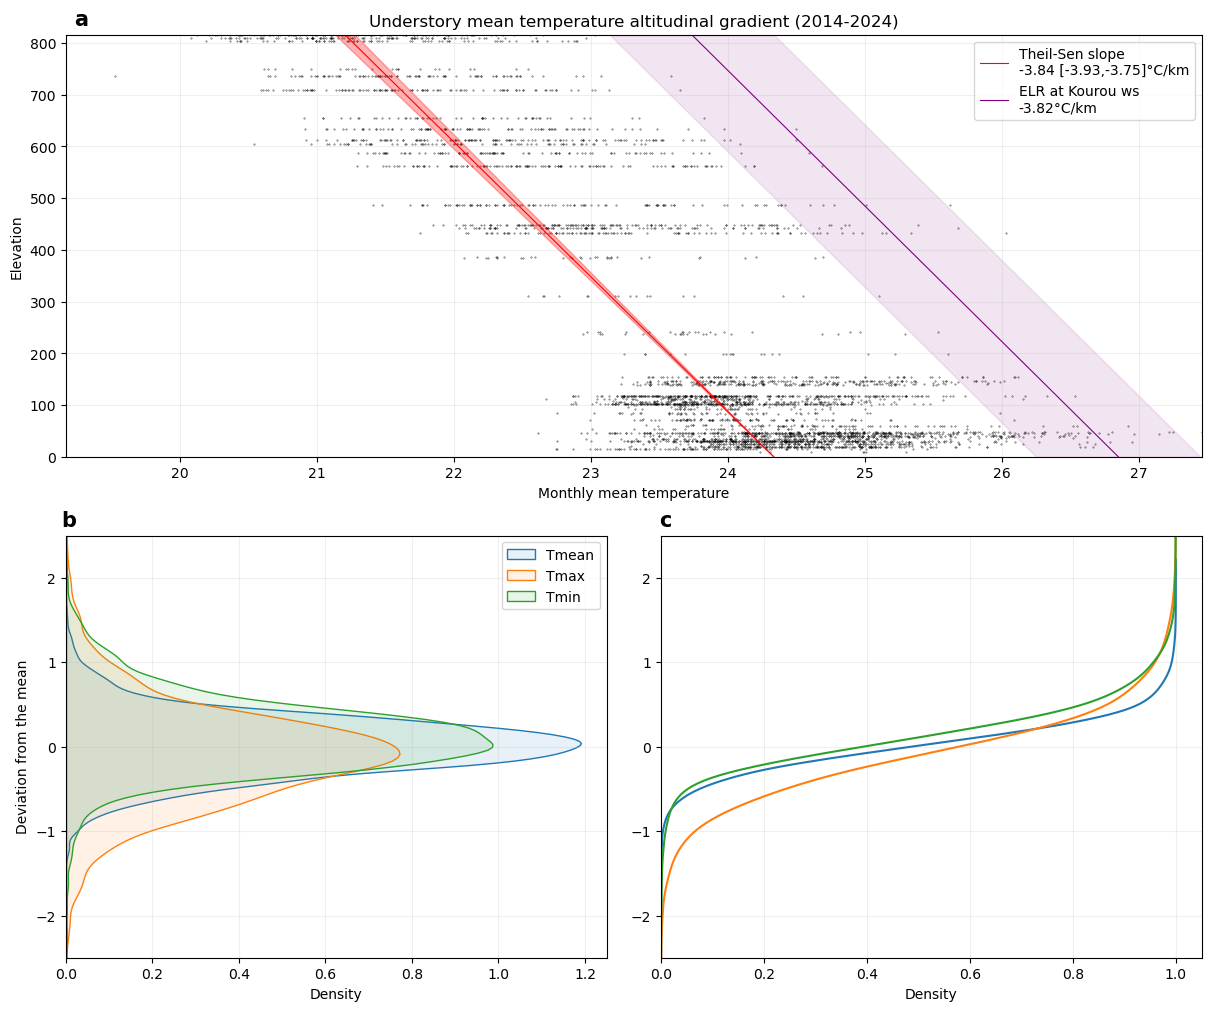

In [723]:
# create figure 4
xtot=[]
xms=[]
yms=[]
lbl=['a','b','c']

fig, ax=plt.subplot_mosaic("aa;bc",figsize=(12, 10), layout="constrained")

# subplot 1

for pmid in df.index.drop_duplicates():   
    x=df.loc[pmid,['date','Tair']].resample('M', on='date').mean()
    y=[int(df.loc[pmid,'Elevation'].values[0])]*len(x)
    #xms.append(df.loc[pmid,'Tair'].mean())
    #yms.append(int(df.loc[pmid,'Elevation'].values[0]))
    x['Altitude']=y
    xtot.append(x)

dtot=pd.concat(xtot).dropna()
dtot.plot.scatter('Tair','Altitude',s=.1, ax=ax["a"],color="k",alpha=.8)

# theilslope
ts_slope, ts_inter, ts_ls, ts_hs = theilslopes(dtot['Tair'],dtot['Altitude'])  # Note the additional underscores (_) to ignore the last three return values
ys=np.arange(0,np.max(dtot['Altitude']),np.max(dtot['Altitude'])-1)

ax["a"].plot(ts_slope*ys+ts_inter,ys, c='r', linewidth=.8, label='Theil-Sen slope \n'+ str(round(ts_slope*1000,2))+' ['+str(round(ts_ls*1000,2))+','+str(round(ts_hs*1000,2))+']°C/km')
#ax.plot(ts_hs*ys+ts_inter,ys, c='r',linewidth=.5, label='Theil-Sen slope \n'+ str(round(ts_slope*1000,2))+'['+str(round(ts_ls*1000,2))+','+str(round(ts_hs*1000,2))+']°C/km')
#ax.plot(ts_ls*ys+ts_inter,ys, c='r',linewidth=.5)
ax["a"].fill_betweenx(ys,ts_ls*ys+ts_inter,ts_hs*ys+ts_inter, alpha=.3,color='r')

""" # Theil Sen on yearly mean
ts_slope, ts_inter, ts_ls, ts_hs = theilslopes(xms,np.array(yms).reshape(-1,1))
ax.fill_betweenx(yms,ts_ls*np.array(yms)+ts_inter,ts_hs*np.array(yms)+ts_inter, alpha=.9,color='orange')

# scatter mean and regression on yearly mean
reg = LinearRegression().fit(np.array(yms).reshape(-1,1),xms)
ax.scatter(xms,yms,s=5,marker='*', color='g')
ax.plot(reg.predict(np.array(yms).reshape(-1,1)),yms, c='g',label='Linear Reg on mean \n'+ str(round(reg.coef_[0]*1000,2))+'°C/km')

# scatter mean and regression
reg = LinearRegression().fit(dtot['Altitude'].values.reshape(-1,1),dtot['Tair'].values)
ax.plot(reg.predict(dtot['Altitude'].values.reshape(-1,1)),dtot['Altitude'].values, c='g',label='Linear Reg on mean \n'+ str(round(reg.coef_[0]*1000,2))+'°C/km')
"""

# plot Kourou weather station and outside forest lapse rate
MFk=MF_Kourou[MF_Kourou.index>'2014-01-01']['Tair']
mean=MFk.resample('M').mean().mean()
std=MFk.resample('M').mean().std()

xx=ELR*ys+mean
ax["a"].plot(xx,ys, c='purple',linewidth=.8, label='ELR at Kourou ws \n'+ str(round(ELR*1000,2))+'°C/km')
ax["a"].fill_betweenx(ys,xx-std,xx+std, color='purple', alpha=.1)
ax["a"].set_xlabel('Monthly mean temperature')
ax["a"].set_ylabel('Elevation')
ax["a"].margins(False)
ax["a"].legend()
ax["a"].set_title('Understory mean temperature altitudinal gradient (2014-2024)')


# subplot2 
sns.kdeplot(anomean, y='Anom', fill=True, alpha=.1, label='Tmean', ax=ax["b"])
sns.kdeplot(anomax, y='Anom', fill=True, alpha=.1, label='Tmax', ax=ax["b"])
sns.kdeplot(anomin, y='Anom', fill=True, alpha=.1, label='Tmin', ax=ax["b"])

sns.kdeplot(anomean, y='Anom', cumulative=True, ax=ax["c"])
sns.kdeplot(anomax, y='Anom', cumulative=True,  ax=ax["c"])
sns.kdeplot(anomin, y='Anom', cumulative=True, ax=ax["c"])
#ax[1].axvline(0.9)
ax["b"].set_ylabel('Deviation from the mean')
ax["b"].legend()
ax["b"].set_ylim(-2.5,2.5)
#ax["c"].set_ylim(-2.5,2.5)
[ax[k].grid(alpha=.2) for k in lbl]
[ax[k].text(0.02, 1.06, k, 
            transform=ax[k].transAxes,fontsize=15, fontweight='bold', va='top', ha='right') for k in lbl]
ax["c"].sharey(ax['b'])
ax["c"].set_ylabel('')

plt.savefig(figpath+'fig_4.png')

### Figure 5

In [171]:
df=df.set_index('date')
df['erac']=pd.Series(dtype=float) #test.set_index(['date','Raw_data_identifier'])
df['erach']=pd.Series(dtype=float) #test.set_index(['date','Raw_data_identifier'])

lid=df['Raw_data_identifier'].drop_duplicates()

for id in lid:
    dindices=list(df[df['Raw_data_identifier']==id].index)
    df.loc[df['Raw_data_identifier']==id,'erac'] = ERA_f_elr_m[ERA_f_elr_m[id].index.isin(dindices)][id]
    df.loc[df['Raw_data_identifier']==id,'erach'] = ERA_f_elr_h[ERA_f_elr_h[id].index.isin(dindices)][id]

df=df.reset_index()

LAU
PAR
NOU
ITO1
ITO2
ITO3


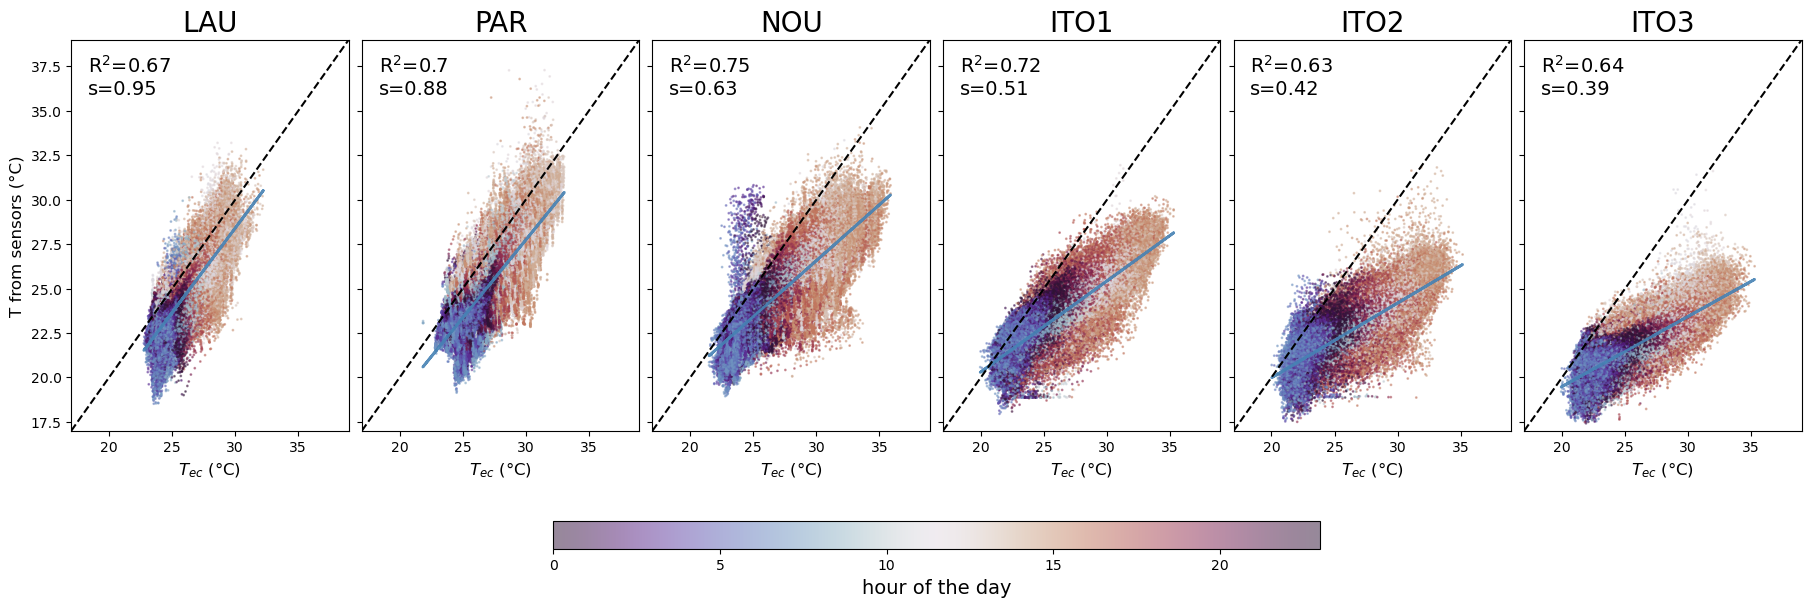

In [180]:
### Plot scatterplot monthly debiased ERA5-Land and microclimate  

fig, ax = plt.subplots(1,6, sharey=True, sharex=True, figsize=(18,6),constrained_layout=True)
ForestClasses=['LAU','PAR','NOU','ITO1','ITO2','ITO3']
lims=(17,39)

for i,n in enumerate(ForestClasses):
    print(n)

    # select data
    subset=df[(df['ForestClass']==n)][['date','Tair','erac']].dropna().set_index('date')
    macro=subset['erac']
    micro=subset['Tair']

    col=[float(d.strftime('%H')) for d in micro.index.time]

    #linear regression
    x,y= macro.values.reshape(-1,1), micro.values
    reg = LinearRegression().fit(x,y)
    scatter=ax[i].scatter(x,y,s=1, alpha=.5, c=col, cmap='twilight_shifted')
    ax[i].plot(x, reg.predict(x),c='steelblue',linewidth=2,alpha=.9)
    ax[i].axline((0, 0), slope=1,c='k', linestyle='--')
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)
    ax[i].set_xlabel('$T_{ec}$ (°C)',fontsize =12)
    ax[i].set_title(n,fontsize =20)
    ax[i].text(0.06,0.86,'R$^2$='+str(round(reg.score(x,y),2))+'\ns='+str(round(reg.coef_[0],2)),
               fontsize =14, transform=ax[i].transAxes)
ax[0].set_ylabel('T from sensors (°C)',fontsize =12)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat], location='bottom', orientation='horizontal', 
                                pad=0.1, aspect=28, fraction=0.07)
cbar=plt.colorbar(scatter, cax=cax, orientation='horizontal')
cbar.set_label('hour of the day',fontsize =14)

plt.savefig(figpath+'fig_5.png')

### Figure 6

### Statistics

In [255]:
# seasonal temperature range for years before 2023
dfm=df.resample('M', on='date')['Tair_sl'].mean()
dfmstd=df.resample('M', on='date')['Tair_sl'].std()

dry=dfm[(dfm.index.month>=9) & (dfm.index.month<=11) & (dfm.index.year<2023)].mean()
dry_std=dfm[(dfm.index.month>=9) & (dfm.index.month<=11) & (dfm.index.year<2023)].std()
wet=dfm[(dfm.index.month>=1) & (dfm.index.month<=2) & (dfm.index.year<2023)].mean()
wet_std=dfm[(dfm.index.month>=1) & (dfm.index.month<=2) & (dfm.index.year<2023)].std()
interseason_Trange=dry-wet
print(str(interseason_Trange)+'['+str(interseason_Trange-(dry_std+wet_std))+','+str(interseason_Trange+(dry_std+wet_std))+']')

1.3552151020413987[0.8419084320086819,1.8685217720741156]


In [287]:
# 2023 temperature range for years before 2023
dfm2023X=dfm[(dfm.index.year==2023)].max()
dfm2023N=dfm[(dfm.index.year==2023)].min()
print(dfm2023X-dfm2023N)

3.0969154746942174
0.9414388839058535
